<a href="https://colab.research.google.com/github/Siddharth2908/AIML/blob/master/CNN_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

    100% |████████████████████████████████| 122kB 3.7MB/s 
    100% |████████████████████████████████| 3.6MB 9.2MB/s 
    100% |████████████████████████████████| 496.4MB 39kB/s 
    100% |████████████████████████████████| 1.5MB 5.7MB/s 
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 48.5MB 1.0MB/s 
    100% |████████████████████████████████| 81kB 24.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built feather-format bcolz
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51
    100% |████████████████████████████████| 51kB 1.8MB/s 
  Stored in direc

In [2]:
!pip uninstall -y pillow==4.0.0

Uninstalling Pillow-4.3.0:
  Successfully uninstalled Pillow-4.3.0


In [3]:
!pip install pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 1.1MB/s 
scikit-image 0.14.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [4]:
!pip uninstall -y torch==0.3.1

Uninstalling torch-0.3.1:
  Successfully uninstalled torch-0.3.1


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

In [6]:
print(platform, accelerator)

cp36-cp36m cu90


In [7]:
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

    100% |████████████████████████████████| 566.4MB 47.5MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.0 which is incompatible.
0.4.0
True


In [0]:
from fastai.conv_learner import *
from cv2 import resize
%matplotlib inline

In [0]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [0]:
class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = vgg16(pre=True).cuda().eval()
        set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 103333790.92it/s]


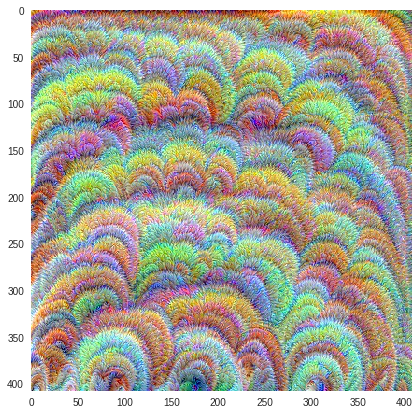

In [11]:
layer = 30
filter = 180

FV = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter, blur=5)

img = PIL.Image.open("layer_"+str(layer)+"_filter_"+str(filter)+".jpg")
plt.figure(figsize=(7,7))
plt.grid(None)
plt.imshow(img)